In [8]:
import pandas as pd 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import os 
import numpy as np
# !pip install pyreadr
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from lifelines.plotting import add_at_risk_counts

In [9]:
# Model path 

base_directory = "/mnt/ncshare/ozkilim/BRCA/results/platinum_responce_results_5e4/HGSOC_TRAIN_TCGA_15_PorpoiseMMF_concat_60_ViT_primary_s1"


In [10]:
def get_model_preds(base_directory):
    """Given a trained model folder generte a df with patients probs and labels."""
    df = pd.read_csv("/mnt/ncshare/ozkilim/BRCA/HGSOC_platinum_responce/HGSOC_TCGA_main.csv")
    # remove proteins columns...
    columns_to_drop = [col for col in df.columns if (col.isupper() or "orf" in col)]
    # Drop these columns from the DataFrame.
    main_df = df.drop(columns=columns_to_drop)
    ensemble_data = []
    # Loop through the files in the base directory
    for i in range(5):
        file_path = os.path.join(base_directory, f'split_{i}_results.pkl')
        df = pd.read_pickle(file_path)
        # Extract data
        for key, value in df.items():
            slide_id = str(value['slide_id'])  # Convert slide_id to string
            prob = value['prob'][0][1]        # Assuming this is already a scalar
            label = str(value['label'])       # Convert label to string
            ensemble_data.append({'slide_id': slide_id, 'prob': prob, 'label': label})

    # Creating DataFrame from the collected data
    ensemble_df = pd.DataFrame(ensemble_data)
    # Convert 'slide_id' and 'label' to string if they are not already
    ensemble_df['slide_id'] = ensemble_df['slide_id'].astype(str)
    ensemble_df['label'] = ensemble_df['label'].astype(str)
    # Compute the mean probability for each slide_id and label
    ensemble_df['slide_id'] = ensemble_df['slide_id'].astype(str)
    ensemble_df['label'] = ensemble_df['label'].astype(str)
    # Compute the mean probability for each slide_id and label
    mean_probs_df = ensemble_df.groupby(['slide_id', 'label'], as_index=False).mean()

    merged_df = main_df.merge(mean_probs_df[['slide_id','prob']], on='slide_id', how='left')

    HRD = pd.read_csv("/mnt/ncshare/ozkilim/BRCA/data/HGSOC_processed_data/Patients_HRDscore.txt",sep="\t")
    HRD["case_id"] = HRD["PatientID"]
    merged_df = merged_df.merge(HRD,on="case_id")

    merged_df['slide_type'] = merged_df['slide_id'].str.extract(r'-([^-\.]+)\.')
    merged_df = merged_df.groupby('case_id')['prob','label','HRDscore'].mean().reset_index()

    return merged_df

### Merging all relevant tables

In [11]:
# Data Loading
tcgasurv = pd.read_excel("/mnt/ncshare/ozkilim/BRCA/data/survival_scripts/TCGA-CDR-SupplementalTableS1.xlsx", sheet_name="TCGA-CDR")
tcgasurv2 = pd.read_excel("/mnt/ncshare/ozkilim/BRCA/data/survival_scripts/TCGA-CDR-SupplementalTableS1.xlsx", sheet_name="ExtraEndpoints")
tcgasurv = pd.merge(tcgasurv, tcgasurv2, on="bcr_patient_barcode")
# Data Manipulation
tcgasurv['stage_categories'] = np.where(tcgasurv['ajcc_pathologic_tumor_stage'].isin(["Stage I", "Stage IA", "Stage IB"]), "Stage I",
                                np.where(tcgasurv['ajcc_pathologic_tumor_stage'].isin(["Stage II", "Stage IIA", "Stage IIB"]), "Stage II",
                                np.where(tcgasurv['ajcc_pathologic_tumor_stage'].isin(["Stage III", "Stage IIIA", "Stage IIIB", "Stage IIIC"]), "Stage III",
                                np.where(tcgasurv['ajcc_pathologic_tumor_stage'] == "Stage IV", "Stage IV", np.nan))))

for column in ['OS.time', 'DSS.time', 'DFI.time', 'PFI.time', 'PFS.time']:
    tcgasurv[column] = tcgasurv[column] / 30.5

allclinical = pyreadr.read_r("/mnt/ncshare/ozkilim/BRCA/data/survival_scripts/allclinical_TCGA.RData")
allclinical = allclinical['allclinical']

allclinical = pd.merge(allclinical, tcgasurv, left_on="submitter_id", right_on="bcr_patient_barcode")
allclinical['age_at_diagnosis_years'] = allclinical['age_at_diagnosis'] / 365.25
allclinical['age_cat70'] = np.where(allclinical['age_at_diagnosis_years'] >= 70, ">=70", "<70")

# More Data Loading and Merging
panTCGA_drug_treatment = pd.read_csv("/mnt/ncshare/ozkilim/BRCA/data/TCGA_metadata/panTCGA_drug_treatment.txt", sep='\t')

drugs = pd.read_csv("/mnt/ncshare/ozkilim/BRCA/data/survival_scripts/hnsc_lusc_luad_ov_breast_drugs.txt", sep='\t')
plat_patients = panTCGA_drug_treatment[panTCGA_drug_treatment['pharmaceutical_therapy_drug_name'].str.lower().isin(drugs[drugs['platina'] == 1]['Drug'].str.lower())]['bcr_patient_barcode'].unique()

# here load the model...
wsi = get_model_preds(base_directory)

brca = pd.read_csv('/mnt/ncshare/ozkilim/BRCA/data/survival_scripts/10780432ccr210981-sup-262479_2_supp_7287946_qwylwd.txt', sep='\t')
merged = pd.merge(brca, allclinical, left_on='PatientID', right_on='submitter_id')
merged['case_id'] = merged['PatientID']

merged = pd.merge(merged, wsi, on='case_id')

/home/ozkilim/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:28: DtypeWarning: Columns (5283,7094) have mixed types.Specify dtype option on import or set low_memory=False.
/home/ozkilim/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [18]:
merged.columns.to_list()


# Zsofia finds 115 samples here! correct ... this may be cuase of results change...
merged["BRCA status"] = np.where(merged["BRCA-status_simplified"] == 'intact', 1, 0)
 
merged['HRDscore_normalized'] = merged['HRDscore'] / 100.0
y_true = merged['label']

print(y_true)

# Initialize variables to keep track of the best AUC and coefficients
best_auc = 0
best_coeffs = (0, 0)

for coeff_prob in np.arange(0, 1.01, 0.01):
    for coeff_hrd in np.arange(0, 1.01, 0.01):
        # Ensure the sum of coefficients is 1
        if coeff_prob + coeff_hrd == 1:
            # Calculate the ensemble score with current coefficients
            merged['ensemble'] = (coeff_prob * merged['prob'] + coeff_hrd * merged['HRDscore_normalized'])
            
            print(merged['prob'].to_list()) # nans in prob.... not correct... 
            # Calculate AUC for the current ensemble
            current_auc = roc_auc_score(y_true, merged['ensemble'])
            
            # Update the best AUC and coefficients if the current AUC is better
            if current_auc > best_auc:
                best_auc = current_auc
                best_coeffs = (coeff_prob, coeff_hrd)

# print(f"Best AUC: {best_auc}")
# print(f"Best Coefficients: prob={best_coeffs[0]}, HRDscore_normalized={best_coeffs[1]}")
merged['ensemble'] = (merged['prob'] + merged['HRDscore_normalized']) / 2
merged['ensemble_optimal'] = (best_coeffs[0] * merged['prob'] + best_coeffs[1] * merged['HRDscore_normalized'])

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
87    1.0
88    1.0
89    1.0
90    1.0
91    0.0
Name: label, Length: 92, dtype: float64
[4.483306668134901e-07, 0.3518816828727722, 1.0, 1.0, 0.4103527069091797, 4.769309452967718e-05, 0.5479196906089783, 0.998418390750885, 1.9846439158754947e-07, 1.0, 1.0, 4.256830652593635e-05, 0.6000471711158752, 1.0, 0.4245336055755615, 0.9999998211860657, 1.9293662489872077e-07, 0.0007493100711144507, 0.9994023442268372, 1.0, 0.2465626448392868, 0.999999463558197, nan, 1.0, 1.0, 0.1771233081817627, 0.5418072938919067, 0.9999992251396179, 2.82370223203543e-07, 0.04339020699262619, 0.010254066437482834, 0.6043301224708557, 0.5974805951118469, 0.0003652598534245044, 0.9999803304672241, 1.0, 1.0, 1.0, 0.0006961450562812388, 0.0002819078217726201, 0.005341031588613987, 2.1700454453821294e-05, 0.006414475850760937, 0.6187787652015686, 0.9999996423721313, 0.4869201183319092, 0.7593438625335693, 0.0016165514243766665, 0.00016247933672275394, 0.

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

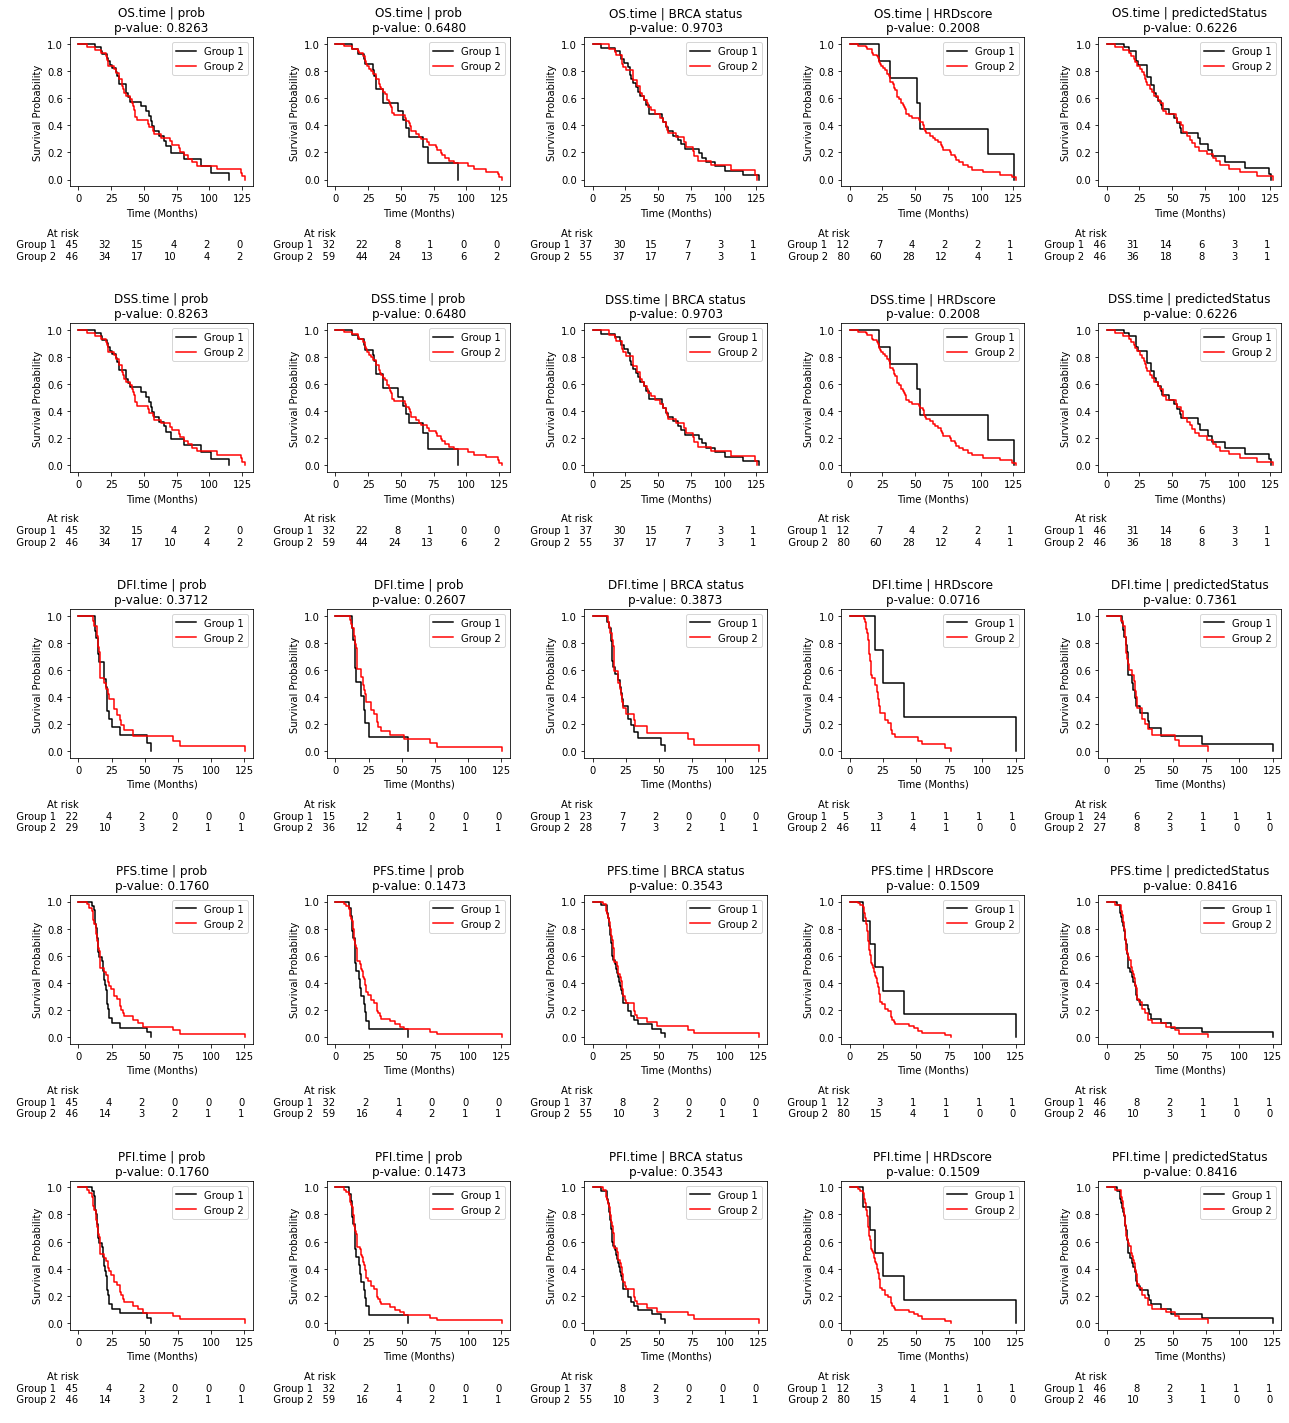

In [ ]:
times = ['OS.time','DSS.time','DFI.time','PFS.time','PFI.time']
thresholds = [0.5,0.5,0.5,42,0.9]
groupings = ['prob','ensemble_optimal','BRCA status','HRDscore','predictedStatus']

# TODO: etup BRCA groups and cutoff and labels.. 


plt.figure(figsize=(18, 20))  # Adjusting the figure size for a 5x5 grid

# Flatten the grid loop since we're just iterating through each combination
for i, time in enumerate(times):
    for j, grouping in enumerate(groupings):
        ax = plt.subplot(5, 5, i * 5 + j + 1)
        
        # Apply the threshold uniformly for demonstration
        threshold = thresholds[j]  # This assumes a 1:1 mapping for simplicity

        merged_no_nans = merged.dropna(subset=[time])

        group1 = merged_no_nans[merged_no_nans[grouping] < threshold]
        group2 = merged_no_nans[merged_no_nans[grouping] >= threshold]

        kmf1 = KaplanMeierFitter()
        kmf2 = KaplanMeierFitter()

        # Check for sufficient data

        kmf1.fit(durations=group1[time], event_observed=group1['label'], label='Group 1')
        kmf2.fit(durations=group2[time], event_observed=group2['label'], label='Group 2')

        # Plotting
        kmf1.plot_survival_function(ci_show=False, ax=ax,color='black')
        kmf2.plot_survival_function(ci_show=False, ax=ax,color='red')
        add_at_risk_counts(kmf1, kmf2,rows_to_show=['At risk'],xticks=[0,25,50,75,100,125])

        # Log-rank test and displaying p-value
        results = logrank_test(group1[time], group2[time], event_observed_A=group1['label'], event_observed_B=group2['label'])
        ax.set_title(f'{time} | {grouping}\np-value: {results.p_value:.4f}')
        ax.set_xlabel('Time (Months)')
        ax.set_ylabel('Survival Probability')

plt.tight_layout()
plt.show()